# Install Transformers Library

In [ ]:
!pip install transformers==3.0.2

In [ ]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import TFAutoModel, AutoTokenizer


# specify GPU
device = torch.device("cuda")

# Import BERT Model and BERT Tokenizer

In [ ]:
#BASE_MODEL = 'bert-base-uncased'
#BASE_MODEL = 'bert-base-multilingual-cased'
BASE_MODEL = 'xlm-roberta-large'

if 'roberta' in BASE_MODEL:
  # Import xlm-roberta pretrained model and load the corresponding tokenizer
  bert = transformers.XLMRobertaModel.from_pretrained(BASE_MODEL)
  tokenizer = transformers.XLMRobertaTokenizer.from_pretrained(BASE_MODEL)
else:
  # Import BERT-base pretrained model and load the BERT tokenizer
  bert = AutoModel.from_pretrained(BASE_MODEL)
  tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL)

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[0, 903, 83, 10, 770, 18, 3299, 57143, 2, 1, 1], [0, 642, 1221, 5885, 9, 45091, 10, 770, 18, 3299, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Load Dataset

In [ ]:
def data_preprocessing(df):
  """
  Data preprocessing
  df: data frame
  """
  for idx, row in df.iterrows():
    text = df.at[idx, 'text']

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    # Remove URL
    text = re.sub(r'https?://\S+|www\.\S+', '',text)
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])    
    # Remove html
    text = re.sub(r'<.*?>', '', text)
    # Remove &gt; <, &lt; >
    text = re.sub(r'&gt;', '',text)
    text = re.sub(r'&lt;', '',text)

    df.at[idx, 'text'] = text

  return df

In [ ]:
# "True" for fine tuning the model with the entire trainset and generating the predictions of devset or testset.
# "False" for fine tuning the model for debugging
EVALUATION_MODE = True

In [ ]:
df = pd.read_csv("trainset_v3.csv")

if EVALUATION_MODE:
  test_df = data_preprocessing(pd.read_csv('testset.csv'))

df.head()

,id,date,text,label
0,1293081923322023937,2020-08-11 07:08:49+00:00,@UNDP_Pakistan with support from @mohrpakistan...,3.0
1,1237132313382838272,2020-03-09 21:45:02+00:00,"Diesen braunen Dreck bekämpfen kann man nur, i...",0.0
2,1169524319535476736,2019-09-05 08:15:01+00:00,#Ukraine pays out 1.1 billion dollars on #Euro...,3.0
3,1318227769621438465,2020-10-19 16:29:26+00:00,Wer verfasst denn beim Landkreis #Harburg die ...,0.0
4,1236003261754134529,2020-03-06 18:58:36+00:00,#Refugees told '#Europe is closed' as tensions...,2.0


In [ ]:
df = data_preprocessing(df)

for idx, row in df.iterrows():
  if df.at[idx, 'label'] == 3:
    df.at[idx, 'label'] = 2

df.head()

,id,date,text,label
0,1293081923322023937,2020-08-11 07:08:49+00:00,@UNDP_Pakistan with support from @mohrpakistan...,2.0
1,1237132313382838272,2020-03-09 21:45:02+00:00,"Diesen braunen Dreck bekämpfen kann man nur, i...",0.0
2,1169524319535476736,2019-09-05 08:15:01+00:00,#Ukraine pays out . billion dollars on #Eurobo...,2.0
3,1318227769621438465,2020-10-19 16:29:26+00:00,Wer verfasst denn beim Landkreis #Harburg die ...,0.0
4,1236003261754134529,2020-03-06 18:58:36+00:00,#Refugees told '#Europe is closed' as tensions...,2.0


In [ ]:
df.shape

(2398, 4)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

0.0    0.461635
2.0    0.301084
1.0    0.237281
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
if not EVALUATION_MODE:
  train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], random_state=2018, test_size=0.2, stratify=df['label'])
  # Use temp_text and temp_labels to create validation and test set
  val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)
else:
  train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['label'], random_state=2018, test_size=0.1, stratify=df['label'])
  test_text = test_df['text']

# Tokenization

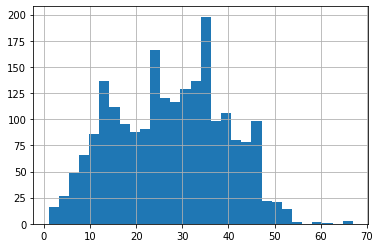

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 64

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
if not EVALUATION_MODE:
  test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8 # 8, 16, 32, min=4 for roberta, 5 for bert

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
"""
if 'roberta' not in BASE_MODEL:
  for param in bert.parameters():
    param.requires_grad = False
"""

"\nif 'roberta' not in BASE_MODEL:\n  for param in bert.parameters():\n    param.requires_grad = False\n"

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.3)
      
      # Sigmoid activation function works better than nn.ReLU() for roberta
      self.activ_fun =  nn.Sigmoid()
      #self.activ_fun =  nn.ReLU()

      # dense layer 1
      input_size = 1024 if 'roberta' in BASE_MODEL else 768
      self.fc1 = nn.Linear(input_size, 512) 
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512, 3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.activ_fun(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-6)  # 5e-6 work with batch size 8; 0.5e-5

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.72222222 1.40494792 1.10666667]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.long())
    
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels.long())

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

early_stop = 0

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'saved_weights.pt')
      print('### best model with the lowest validation loss is saved ###')
      early_stop = 0
    else:
      early_stop += 1
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    if early_stop == 3:
      # If validation loss increases in 3 epochs, stop the training process
      break


 Epoch 1 / 10
  Batch    50  of    270.
  Batch   100  of    270.
  Batch   150  of    270.
  Batch   200  of    270.
  Batch   250  of    270.

Evaluating...
### best model with the lowest validation loss is saved ###

Training Loss: 1.113
Validation Loss: 1.091

 Epoch 2 / 10
  Batch    50  of    270.
  Batch   100  of    270.
  Batch   150  of    270.
  Batch   200  of    270.
  Batch   250  of    270.

Evaluating...
### best model with the lowest validation loss is saved ###

Training Loss: 1.010
Validation Loss: 0.997

 Epoch 3 / 10
  Batch    50  of    270.
  Batch   100  of    270.
  Batch   150  of    270.
  Batch   200  of    270.
  Batch   250  of    270.

Evaluating...
### best model with the lowest validation loss is saved ###

Training Loss: 0.882
Validation Loss: 0.941

 Epoch 4 / 10
  Batch    50  of    270.
  Batch   100  of    270.
  Batch   150  of    270.
  Batch   200  of    270.
  Batch   250  of    270.

Evaluating...
### best model with the lowest validation los

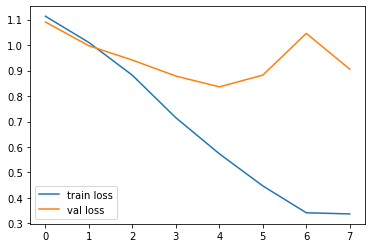

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='val loss')
plt.legend()

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)

In [ ]:
if not EVALUATION_MODE:
  print(classification_report(test_y, preds))
else:
  results = pd.DataFrame(data=preds, columns=['label'])
  results.to_csv('answer.csv', index=False)
  print('answer.csv is saved.')

answer.csv is saved.


In [ ]:
#pd.crosstab(test_y, preds)